In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ============================================================================
# COMBINE MULTIPLE YEAR DATA FILES WITH UNIQUE PATIENT IDENTIFICATION
# ============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

print("="*80)
print("COMBINING MULTI-YEAR MEDICAL DATA WITH UNIQUE PATIENT IDS")
print("="*80)

COMBINING MULTI-YEAR MEDICAL DATA WITH UNIQUE PATIENT IDS


In [3]:


# ============================================================================
# STEP 1: LOAD BOTH YEAR FILES
# ============================================================================
print("\n📁 Step 1: Loading data from both years...")

# Load year 1401 data
df_1401 = pd.read_excel("Results1401.xlsx")
print(f"✓ Year 1401: {len(df_1401)} records, {df_1401['PID'].nunique()} unique PIDs")

# Load year 1402 data
df_1402 = pd.read_excel("Results1402.xlsx")  # Update filename as needed
print(f"✓ Year 1402: {len(df_1402)} records, {df_1402['PID'].nunique()} unique PIDs")

# ============================================================================
# STEP 2: CREATE UNIQUE IDENTIFIERS
# ============================================================================
print("\n🔑 Step 2: Creating unique patient identifiers...")

# Add year column to each dataset
df_1401['Year'] = 1401
df_1402['Year'] = 1402

# Create unique patient ID by combining Year and PID
# Format: "YEAR_PID" (e.g., "1401_2", "1402_2" are different patients)
df_1401['UniqueID'] = df_1401['Year'].astype(str) + '_' + df_1401['PID'].astype(str)
df_1402['UniqueID'] = df_1402['Year'].astype(str) + '_' + df_1402['PID'].astype(str)

print(f"✓ Created unique IDs for year 1401 (e.g., {df_1401['UniqueID'].iloc[0]})")
print(f"✓ Created unique IDs for year 1402 (e.g., {df_1402['UniqueID'].iloc[0]})")

# ============================================================================
# STEP 3: COMBINE THE DATASETS
# ============================================================================
print("\n🔄 Step 3: Combining datasets...")

# Combine both dataframes
df_combined = pd.concat([df_1401, df_1402], ignore_index=True)

print(f"✓ Combined dataset: {len(df_combined)} total records")
print(f"✓ Total unique patients: {df_combined['UniqueID'].nunique()}")
print(f"✓ Years included: {df_combined['Year'].unique()}")

# ============================================================================
# STEP 4: PROCESS COMBINED DATA
# ============================================================================
print("\n🧹 Step 4: Processing combined data...")

def process_result(value):
    """Convert various result formats to numeric values"""
    try:
        if isinstance(value, str):
            if value.strip().lower() in ['*', 'negative', 'positive', '']:
                return None
            value = value.replace('<', '').replace('>', '').strip()
            if '/' in value:
                parts = value.split('/')
                numeric_parts = []
                for part in parts:
                    try:
                        numeric_parts.append(float(part.strip()))
                    except:
                        pass
                if numeric_parts:
                    return np.mean(numeric_parts)
            value = value.replace(",", ".")
        return float(value)
    except:
        return None

# Process Result column
df_combined["Result"] = df_combined["Result"].apply(process_result)
valid_results = df_combined["Result"].notna().sum()
print(f"✓ Processed results: {valid_results}/{len(df_combined)} valid numeric values")

# ============================================================================
# STEP 5: CREATE TARGET VARIABLE
# ============================================================================
print("\n🎯 Step 5: Creating target variable based on HbA1c...")

# Create target for combined data
df_combined["HbA1C_Flag"] = df_combined.apply(
    lambda row: 1 if row["TName"] == "Hb A1C" and pd.notna(row["Result"]) and row["Result"] >= 6.5 else 0,
    axis=1
)

# Map to patient level using UniqueID (not PID)
pid_target = df_combined.groupby("UniqueID")["HbA1C_Flag"].max()
df_combined["Target"] = df_combined["UniqueID"].map(pid_target)
df_combined = df_combined.drop(columns=["HbA1C_Flag"])

# Check target distribution by year
print("\nTarget distribution by year:")
for year in [1401, 1402]:
    year_data = df_combined[df_combined['Year'] == year]
    target_dist = year_data.groupby('UniqueID')['Target'].first().value_counts()
    print(f"\nYear {year}:")
    print(f"  Non-diabetic (0): {target_dist.get(0, 0)} patients")
    print(f"  Diabetic (1): {target_dist.get(1, 0)} patients")

# ============================================================================
# STEP 6: PIVOT COMBINED DATA
# ============================================================================
print("\n📊 Step 6: Pivoting combined data...")

# Group by UniqueID instead of PID
df_grouped = df_combined.groupby(['UniqueID', 'TName', 'Target', 'Year'])['Result'].mean().reset_index()

# Pivot with UniqueID
df_pivot = df_grouped.pivot(index=['UniqueID', 'Target', 'Year'], 
                            columns='TName', 
                            values='Result').reset_index()

print(f"✓ Pivoted data: {df_pivot.shape[0]} unique patients × {df_pivot.shape[1]-3} features")

# ============================================================================
# STEP 7: HANDLE MISSING VALUES
# ============================================================================
print("\n🔧 Step 7: Handling missing values...")

# Fill missing values with median per test
for col in df_pivot.columns:
    if col not in ['UniqueID', 'Target', 'Year']:
        median_val = df_pivot[col].median()
        if pd.notna(median_val):
            df_pivot[col] = df_pivot[col].fillna(median_val)
        else:
            df_pivot[col] = df_pivot[col].fillna(0)

print("✓ Missing values filled with median per test")

# ============================================================================
# STEP 8: PREPARE FOR MACHINE LEARNING
# ============================================================================
print("\n🎯 Step 8: Preparing for machine learning...")

# Separate features and target
X = df_pivot.drop(['UniqueID', 'Target', 'Year'], axis=1)
y = df_pivot['Target']

# Also keep year information for potential stratified splitting
years = df_pivot['Year']
unique_ids = df_pivot['UniqueID']

print(f"✓ Feature matrix: {X.shape}")
print(f"✓ Target vector: {y.shape}")

# ============================================================================
# STEP 9: CREATE TRAIN-TEST SPLIT
# ============================================================================
print("\n✂️ Step 9: Creating train-test split...")

# Option 1: Random split (patients from both years in train and test)
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, unique_ids,
    test_size=0.2, 
    random_state=2, 
    stratify=y
)

print("\n📊 Option 1 - Random Split:")
print(f"Training: {len(X_train)} patients")
print(f"Testing: {len(X_test)} patients")

# Option 2: Time-based split (train on 1401, test on 1402)
train_mask = years == 1401
test_mask = years == 1402

X_train_time = X[train_mask]
X_test_time = X[test_mask]
y_train_time = y[train_mask]
y_test_time = y[test_mask]

print("\n📊 Option 2 - Time-based Split:")
print(f"Training (1401): {len(X_train_time)} patients")
print(f"Testing (1402): {len(X_test_time)} patients")

# ============================================================================
# STEP 10: SAVE COMBINED DATA
# ============================================================================
print("\n💾 Step 10: Saving processed data...")

# Save the combined pivoted data
df_pivot.to_excel("combined_data_1401_1402_pivoted.xlsx", index=False)
print("✓ Saved combined pivoted data")

# Save the combined raw data
df_combined.to_excel("combined_data_1401_1402_raw.xlsx", index=False)
print("✓ Saved combined raw data")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("✅ DATA COMBINATION COMPLETE")
print("="*80)
print(f"\nCombined Statistics:")
print(f"• Total unique patients: {df_pivot['UniqueID'].nunique()}")
print(f"• Total features: {X.shape[1]}")
print(f"• Years included: 1401, 1402")
print(f"• Class distribution: {y.value_counts().to_dict()}")

print("\n📝 Important Notes:")
print("• Each patient has a unique ID: YEAR_PID (e.g., '1401_2', '1402_2')")
print("• PID=2 in 1401 and PID=2 in 1402 are treated as DIFFERENT patients")
print("• You can use either random split or time-based split for training")

print("\n🎯 Next Steps:")
print("1. Use X_train, X_test, y_train, y_test for model training")
print("2. Or use X_train_time, X_test_time for temporal validation")
print("3. The combined data has more samples for better model training")

print("="*80)

# Make variables available globally
print("\n✓ Variables ready for use:")
print("  - X_train, X_test, y_train, y_test (random split)")
print("  - X_train_time, X_test_time, y_train_time, y_test_time (time split)")
print("  - df_combined (raw combined data)")
print("  - df_pivot (pivoted combined data)")

# Convert y_train to 1D array for sklearn
y_train = np.ravel(y_train)
y_train_time = np.ravel(y_train_time)


📁 Step 1: Loading data from both years...
✓ Year 1401: 48465 records, 2659 unique PIDs
✓ Year 1402: 32930 records, 2097 unique PIDs

🔑 Step 2: Creating unique patient identifiers...
✓ Created unique IDs for year 1401 (e.g., 1401_2)
✓ Created unique IDs for year 1402 (e.g., 1402_1)

🔄 Step 3: Combining datasets...
✓ Combined dataset: 81395 total records
✓ Total unique patients: 4756
✓ Years included: [1401 1402]

🧹 Step 4: Processing combined data...
✓ Processed results: 69334/81395 valid numeric values

🎯 Step 5: Creating target variable based on HbA1c...

Target distribution by year:

Year 1401:
  Non-diabetic (0): 2655 patients
  Diabetic (1): 4 patients

Year 1402:
  Non-diabetic (0): 2096 patients
  Diabetic (1): 1 patients

📊 Step 6: Pivoting combined data...
✓ Pivoted data: 4756 unique patients × 348 features

🔧 Step 7: Handling missing values...
✓ Missing values filled with median per test

🎯 Step 8: Preparing for machine learning...
✓ Feature matrix: (4756, 348)
✓ Target vecto

In [5]:
# ============================================================================
# STEP 1: LOAD DATA
# ============================================================================
print("\n📁 Step 1: Loading data...")
df = pd.read_excel("Results1401.xlsx")
print(f"✓ Loaded {len(df)} records from {df['PID'].nunique()} patients")


📁 Step 1: Loading data...
✓ Loaded 48465 records from 2659 patients


In [22]:
# ============================================================================
# VERIFY DATA IS LOADED
# ============================================================================
try:
    print(f"\n✓ Data check:")
    print(f"  X_train shape: {X_train.shape}")
    print(f"  X_test shape: {X_test.shape}")
    print(f"  y_train shape: {y_train.shape}")
    print(f"  y_test shape: {y_test.shape}")
except NameError:
    print("\n⚠️ ERROR: Data not found!")
    print("Please run the preprocessing code first to create X_train, X_test, y_train, y_test")
    print("Then run this cell again.")

# Store results for comparison
model_results = {}



✓ Data check:
  X_train shape: (2127, 193)
  X_test shape: (532, 193)
  y_train shape: (2127,)
  y_test shape: (532,)


In [6]:
# ============================================================================
# STEP 2: CLEAN RESULT VALUES
# ============================================================================
print("\n🧹 Step 2: Cleaning Result column...")

def process_result(value):
    """Convert various result formats to numeric values"""
    try:
        if isinstance(value, str):
            # Handle special markers
            if value.strip().lower() in ['*', 'negative', 'positive', '']:
                return None
            # Remove comparison operators
            value = value.replace('<', '').replace('>', '').strip()
            # Handle fractions (e.g., "71/68" -> average)
            if '/' in value:
                parts = value.split('/')
                numeric_parts = []
                for part in parts:
                    try:
                        numeric_parts.append(float(part.strip()))
                    except:
                        pass
                if numeric_parts:
                    return np.mean(numeric_parts)
            # Replace decimal separator if needed
            value = value.replace(",", ".")
        return float(value)
    except:
        return None

df["Result"] = df["Result"].apply(process_result)
valid_results = df["Result"].notna().sum()
print(f"✓ Processed results: {valid_results}/{len(df)} valid numeric values")


🧹 Step 2: Cleaning Result column...
✓ Processed results: 41603/48465 valid numeric values


In [7]:
# ============================================================================
# STEP 3: CREATE TARGET VARIABLE
# ============================================================================
print("\n🎯 Step 3: Creating target variable (HbA1c >= 6.5)...")

# Identify diabetic patients based on HbA1c
df["HbA1C_Flag"] = df.apply(
    lambda row: 1 if row["TName"] == "Hb A1C" and pd.notna(row["Result"]) and row["Result"] >= 6.5 else 0,
    axis=1
)

# Map to patient level
pid_target = df.groupby("PID")["HbA1C_Flag"].max()
df["Target"] = df["PID"].map(pid_target)
df = df.drop(columns=["HbA1C_Flag"])

target_dist = df.groupby('PID')['Target'].first().value_counts()
print(f"✓ Target distribution:")
print(f"  - Non-diabetic (Target=0): {target_dist.get(0, 0)} patients")
print(f"  - Diabetic (Target=1): {target_dist.get(1, 0)} patients")

if target_dist.get(1, 0) == 0:
    print("⚠️  WARNING: No diabetic patients found. Check if 'Hb A1C' test name is correct.")



🎯 Step 3: Creating target variable (HbA1c >= 6.5)...
✓ Target distribution:
  - Non-diabetic (Target=0): 2655 patients
  - Diabetic (Target=1): 4 patients


In [8]:
# ============================================================================
# STEP 4: PIVOT TO WIDE FORMAT
# ============================================================================
print("\n🔄 Step 4: Pivoting data (patients as rows, tests as columns)...")

# Group by PID and TName, taking mean of duplicate tests
df_grouped = df.groupby(['PID', 'TName', 'Target'])['Result'].mean().reset_index()

# Pivot to wide format
df_pivot = df_grouped.pivot(index=['PID', 'Target'], columns='TName', values='Result').reset_index()

print(f"✓ Pivoted data shape: {df_pivot.shape[0]} patients × {df_pivot.shape[1]-2} features")


🔄 Step 4: Pivoting data (patients as rows, tests as columns)...
✓ Pivoted data shape: 2659 patients × 302 features


In [9]:
# ============================================================================
# STEP 5: HANDLE MISSING VALUES
# ============================================================================
print("\n🔧 Step 5: Handling missing values...")

# Calculate missing percentage for each test
missing_before = df_pivot.isna().sum()
high_missing = missing_before[missing_before > len(df_pivot) * 0.5]

if len(high_missing) > 0:
    print(f"⚠️  Tests with >50% missing values: {list(high_missing.index[:5])}...")

# Fill missing values with median (best practice for medical data)
for col in df_pivot.columns:
    if col not in ['PID', 'Target']:
        median_val = df_pivot[col].median()
        if pd.notna(median_val):
            df_pivot[col] = df_pivot[col].fillna(median_val)
        else:
            df_pivot[col] = df_pivot[col].fillna(0)

print(f"✓ Missing values filled with median per test")


🔧 Step 5: Handling missing values...
⚠️  Tests with >50% missing values: [' Brucella Ab-IgG (Elisa)', ' Brucella Ab-IgM (Elisa)', ' CMV Ab-IgG (Elisa)', ' CMV Ab-IgM (Elisa)', ' DNA ds Ab (Elisa)']...
✓ Missing values filled with median per test


In [10]:
# ============================================================================
# STEP 6: PREPARE FEATURES AND TARGET
# ============================================================================
print("\n📊 Step 6: Preparing features and target...")

# Separate features and target
X = df_pivot.drop(['PID', 'Target'], axis=1)
y = df_pivot['Target']

# Remove constant features (same value for all patients)
constant_features = X.columns[X.nunique() <= 1]
if len(constant_features) > 0:
    print(f"⚠️  Removing {len(constant_features)} constant features")
    X = X.drop(columns=constant_features)

print(f"✓ Final feature matrix: {X.shape[0]} patients × {X.shape[1]} features")


📊 Step 6: Preparing features and target...
⚠️  Removing 109 constant features
✓ Final feature matrix: 2659 patients × 193 features


In [11]:
# ============================================================================
# STEP 7: TRAIN-TEST SPLIT (BEST PRACTICE: STRATIFIED)
# ============================================================================
print("\n✂️ Step 7: Train-test split (stratified to maintain class balance)...")

# BEST PRACTICE: Stratified split ensures both classes in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=2, 
    stratify=y  # This ensures proportional representation of both classes
)

print(f"✓ Training set: {len(X_train)} patients")
print(f"  - Non-diabetic: {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")
print(f"  - Diabetic: {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")

print(f"✓ Test set: {len(X_test)} patients")
print(f"  - Non-diabetic: {(y_test == 0).sum()} ({(y_test == 0).sum()/len(y_test)*100:.1f}%)")
print(f"  - Diabetic: {(y_test == 1).sum()} ({(y_test == 1).sum()/len(y_test)*100:.1f}%)")


✂️ Step 7: Train-test split (stratified to maintain class balance)...
✓ Training set: 2127 patients
  - Non-diabetic: 2124 (99.9%)
  - Diabetic: 3 (0.1%)
✓ Test set: 532 patients
  - Non-diabetic: 531 (99.8%)
  - Diabetic: 1 (0.2%)


In [12]:
# ============================================================================
# STEP 8: FEATURE SCALING (OPTIONAL BUT RECOMMENDED)
# ============================================================================
print("\n⚖️ Step 8: Standardizing features (mean=0, std=1)...")
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)
print("✓ Features standardized (important for SVM, KNN)")

# Get feature names for later use
feature_names = X_test.columns.tolist()

# ============================================================================
# STEP 9: SAVE PROCESSED DATA
# ============================================================================
print("\n💾 Step 9: Saving processed data...")

# Save the pivoted data
df_pivot.to_excel("processed_data_pivoted.xlsx", index=False)
print("✓ Saved processed data to 'processed_data_pivoted.xlsx'")



⚖️ Step 8: Standardizing features (mean=0, std=1)...
✓ Features standardized (important for SVM, KNN)

💾 Step 9: Saving processed data...
✓ Saved processed data to 'processed_data_pivoted.xlsx'


In [13]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("✅ PREPROCESSING COMPLETE - DATA READY FOR MACHINE LEARNING")
print("="*80)

print("\n📋 SUMMARY:")
print(f"• Total patients: {len(df_pivot)}")
print(f"• Total features: {X.shape[1]}")
print(f"• Class balance: {y.value_counts(normalize=True).to_dict()}")
print(f"• Train-test split: 80%-20%")
print(f"• Both classes present in both sets: ✓")

print("\n🎓 WHY THIS IS BEST PRACTICE:")
print("1. Stratified split maintains class proportions in both sets")
print("2. Model learns from both diabetic AND non-diabetic patterns")
print("3. Test set reflects real-world distribution")
print("4. Metrics (accuracy, precision, recall) are meaningful")
print("5. Model can generalize to new patients")

# Convert y_train to 1D array as required by sklearn
y_train = np.ravel(y_train)
print(f"\n✓ y_train converted to 1D array shape: {y_train.shape}")

print("\n" + "="*80)
print("🚀 READY TO USE IN YOUR NOTEBOOK")
print("="*80)
print("\nVariables ready for your models:")
print("• X_train, X_test, y_train, y_test - for tree-based models (RF, XGBoost)")
print("• X_train_scaled, X_test_scaled - for distance-based models (SVM, KNN)")
print("• feature_names - for feature importance analysis")

print("\n📝 Now you can run your ML models directly:")
print("-"*40)
print("# Your existing code will work as-is:")
print("LR.fit(X_train, y_train)")
print("y_pred = LR.predict(X_test)")
print("-"*40)


✅ PREPROCESSING COMPLETE - DATA READY FOR MACHINE LEARNING

📋 SUMMARY:
• Total patients: 2659
• Total features: 193
• Class balance: {0: 0.9984956750658143, 1: 0.001504324934185784}
• Train-test split: 80%-20%
• Both classes present in both sets: ✓

🎓 WHY THIS IS BEST PRACTICE:
1. Stratified split maintains class proportions in both sets
2. Model learns from both diabetic AND non-diabetic patterns
3. Test set reflects real-world distribution
4. Metrics (accuracy, precision, recall) are meaningful
5. Model can generalize to new patients

✓ y_train converted to 1D array shape: (2127,)

🚀 READY TO USE IN YOUR NOTEBOOK

Variables ready for your models:
• X_train, X_test, y_train, y_test - for tree-based models (RF, XGBoost)
• X_train_scaled, X_test_scaled - for distance-based models (SVM, KNN)
• feature_names - for feature importance analysis

📝 Now you can run your ML models directly:
----------------------------------------
# Your existing code will work as-is:
LR.fit(X_train, y_train)


In [14]:
# ============================================================================
# COMPLETE MACHINE LEARNING MODELS FOR T2DM PREDICTION
# ============================================================================

import numpy as np
import pandas as pd
from numpy import mean, std
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Store results for comparison
model_results = {}


In [23]:
# ============================================================================
# 3.1 LOGISTIC REGRESSION (if not already done)
# ============================================================================
print("\n" + "="*60)
print("3.1 LOGISTIC REGRESSION (LR)")
print("="*60)

# Create and train LR model
LR = LogisticRegression(max_iter=1000)

# Cross-validation
cv = KFold(n_splits=10, random_state=2, shuffle=True)
scores = cross_val_score(LR, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy for training: %.4f (%.4f)' % (mean(scores), std(scores)))

# Fit and predict
LR.fit(X_train, y_train)
y_pred_lr = LR.predict(X_test)

# Results
print('Accuracy for testing: %.4f' % accuracy_score(y_test, y_pred_lr))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, digits=4))

cf_matrix_LR = confusion_matrix(y_test, y_pred_lr)
model_results['LR'] = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'model': LR,
    'predictions': y_pred_lr
}



3.1 LOGISTIC REGRESSION (LR)
Accuracy for training: 0.9962 (0.0028)
Accuracy for testing: 0.9962

Confusion Matrix:
[[530   1]
 [  1   0]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9981    0.9981    0.9981       531
           1     0.0000    0.0000    0.0000         1

    accuracy                         0.9962       532
   macro avg     0.4991    0.4991    0.4991       532
weighted avg     0.9962    0.9962    0.9962       532



In [15]:
# ============================================================================
# 3.2 KNN (K-Nearest Neighbors)
# ============================================================================
print("\n" + "="*60)
print("3.2 K-NEAREST NEIGHBORS (KNN)")
print("="*60)

from sklearn.neighbors import KNeighborsClassifier

# Grid search for best parameters
params_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance']
}

knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, params_knn, cv=10, scoring='accuracy')
grid_knn.fit(X_train, y_train)

print(f"Best parameters: {grid_knn.best_params_}")

# Create model with best parameters
KNN = KNeighborsClassifier(**grid_knn.best_params_)

# Cross-validation
cv = KFold(n_splits=10, random_state=2, shuffle=True)
scores = cross_val_score(KNN, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy for training: %.4f (%.4f)' % (mean(scores), std(scores)))

# Fit and predict
KNN.fit(X_train, y_train)
y_pred_knn = KNN.predict(X_test)

# Results
print('Accuracy for testing: %.4f' % accuracy_score(y_test, y_pred_knn))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, digits=4))

cf_matrix_KNN = confusion_matrix(y_test, y_pred_knn)
model_results['KNN'] = {
    'accuracy': accuracy_score(y_test, y_pred_knn),
    'model': KNN,
    'predictions': y_pred_knn
}


3.2 K-NEAREST NEIGHBORS (KNN)
Best parameters: {'n_neighbors': 3, 'weights': 'uniform'}
Accuracy for training: 0.9986 (0.0022)
Accuracy for testing: 0.9981

Confusion Matrix:
[[531   0]
 [  1   0]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9981    1.0000    0.9991       531
           1     0.0000    0.0000    0.0000         1

    accuracy                         0.9981       532
   macro avg     0.4991    0.5000    0.4995       532
weighted avg     0.9962    0.9981    0.9972       532



In [16]:
# ============================================================================
# 3.3 SVM (Support Vector Machine)
# ============================================================================
print("\n" + "="*60)
print("3.3 SUPPORT VECTOR MACHINE (SVM)")
print("="*60)

from sklearn import svm

# Use scaled data for SVM
SVM = svm.SVC(probability=True, kernel='rbf')

# Cross-validation
cv = KFold(n_splits=10, random_state=2, shuffle=True)
scores = cross_val_score(SVM, X_train_scaled, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy for training: %.4f (%.4f)' % (mean(scores), std(scores)))

# Fit and predict (using scaled data)
SVM.fit(X_train_scaled, y_train)
y_pred_svm = SVM.predict(X_test_scaled)

# Results
print('Accuracy for testing: %.4f' % accuracy_score(y_test, y_pred_svm))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, digits=4))

cf_matrix_SVM = confusion_matrix(y_test, y_pred_svm)
model_results['SVM'] = {
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'model': SVM,
    'predictions': y_pred_svm
}




3.3 SUPPORT VECTOR MACHINE (SVM)
Accuracy for training: 0.9986 (0.0022)
Accuracy for testing: 0.9981

Confusion Matrix:
[[531   0]
 [  1   0]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9981    1.0000    0.9991       531
           1     0.0000    0.0000    0.0000         1

    accuracy                         0.9981       532
   macro avg     0.4991    0.5000    0.4995       532
weighted avg     0.9962    0.9981    0.9972       532



In [17]:
# ============================================================================
# 3.4 NAIVE BAYES
# ============================================================================
print("\n" + "="*60)
print("3.4 NAIVE BAYES (NB)")
print("="*60)

from sklearn.naive_bayes import GaussianNB

NB = GaussianNB()

# Cross-validation
cv = KFold(n_splits=10, random_state=2, shuffle=True)
scores = cross_val_score(NB, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy for training: %.4f (%.4f)' % (mean(scores), std(scores)))

# Fit and predict
NB.fit(X_train, y_train)
y_pred_nb = NB.predict(X_test)

# Results
print('Accuracy for testing: %.4f' % accuracy_score(y_test, y_pred_nb))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb, digits=4))

cf_matrix_NB = confusion_matrix(y_test, y_pred_nb)
model_results['NB'] = {
    'accuracy': accuracy_score(y_test, y_pred_nb),
    'model': NB,
    'predictions': y_pred_nb
}



3.4 NAIVE BAYES (NB)
Accuracy for training: 0.4574 (0.0772)
Accuracy for testing: 0.4342

Confusion Matrix:
[[231 300]
 [  1   0]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9957    0.4350    0.6055       531
           1     0.0000    0.0000    0.0000         1

    accuracy                         0.4342       532
   macro avg     0.4978    0.2175    0.3028       532
weighted avg     0.9938    0.4342    0.6044       532



In [18]:
# ============================================================================
# 3.5 DECISION TREE
# ============================================================================
print("\n" + "="*60)
print("3.5 DECISION TREE (DT)")
print("="*60)

from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier(random_state=2, max_depth=10, min_samples_split=5)

# Cross-validation
cv = KFold(n_splits=10, random_state=2, shuffle=True)
scores = cross_val_score(DT, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy for training: %.4f (%.4f)' % (mean(scores), std(scores)))

# Fit and predict
DT.fit(X_train, y_train)
y_pred_dt = DT.predict(X_test)

# Results
print('Accuracy for testing: %.4f' % accuracy_score(y_test, y_pred_dt))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, digits=4))

cf_matrix_DT = confusion_matrix(y_test, y_pred_dt)
model_results['DT'] = {
    'accuracy': accuracy_score(y_test, y_pred_dt),
    'model': DT,
    'predictions': y_pred_dt
}


3.5 DECISION TREE (DT)
Accuracy for training: 0.9995 (0.0014)
Accuracy for testing: 1.0000

Confusion Matrix:
[[531   0]
 [  0   1]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       531
           1     1.0000    1.0000    1.0000         1

    accuracy                         1.0000       532
   macro avg     1.0000    1.0000    1.0000       532
weighted avg     1.0000    1.0000    1.0000       532



In [19]:
# ============================================================================
# 3.6 RANDOM FOREST
# ============================================================================
print("\n" + "="*60)
print("3.6 RANDOM FOREST (RF)")
print("="*60)

from sklearn.ensemble import RandomForestClassifier

# Grid search for best parameters
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid = RandomForestClassifier(random_state=2)
grid_rf = GridSearchCV(rf_grid, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print(f"Best parameters: {grid_rf.best_params_}")

# Create model with best parameters
RF = RandomForestClassifier(**grid_rf.best_params_, random_state=2)

# Cross-validation
cv = KFold(n_splits=10, random_state=2, shuffle=True)
scores = cross_val_score(RF, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy for training: %.4f (%.4f)' % (mean(scores), std(scores)))

# Fit and predict
RF.fit(X_train, y_train)
y_pred_rf = RF.predict(X_test)

# Results
print('Accuracy for testing: %.4f' % accuracy_score(y_test, y_pred_rf))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, digits=4))

cf_matrix_RF = confusion_matrix(y_test, y_pred_rf)
model_results['RF'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'model': RF,
    'predictions': y_pred_rf
}

# Feature Importance for Random Forest
importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = 10

print(f"\nTop {top_features} Important Features:")
for i in range(min(top_features, len(indices))):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")


3.6 RANDOM FOREST (RF)
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy for training: 0.9986 (0.0022)
Accuracy for testing: 0.9981

Confusion Matrix:
[[531   0]
 [  1   0]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9981    1.0000    0.9991       531
           1     0.0000    0.0000    0.0000         1

    accuracy                         0.9981       532
   macro avg     0.4991    0.5000    0.4995       532
weighted avg     0.9962    0.9981    0.9972       532


Top 10 Important Features:
1. Hb A1C: 0.4591
2. Fasting blood sugar: 0.1337
3. Triglycerides: 0.0662
4. Cholesterol Total: 0.0352
5. M.C.H: 0.0245
6. M.C.V: 0.0204
7. LDL Cholesterol: 0.0189
8. Lymphocytes: 0.0184
9. VLDL Cholesterol: 0.0174
10. Thyroxin Total (T-4)(Elisa): 0.0173


In [20]:
import numpy as np
import pandas as pd
from numpy import mean, std
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [25]:
# ============================================================================
# 3.7 XGBOOST
# ============================================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from numpy import mean, std

print("="*60)
print("XGBOOST WITH DATA VALIDATION")
print("="*60)


XGBOOST WITH DATA VALIDATION


In [26]:
# ============================================================================
# STEP 1: VALIDATE AND FIX DATA
# ============================================================================
print("\n📋 Checking data format...")

# Check data shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Ensure y_train is 1D array
if len(y_train.shape) > 1:
    print("⚠️ Converting y_train to 1D array...")
    y_train = np.ravel(y_train)
    print(f"✓ New y_train shape: {y_train.shape}")

# Check for NaN values
if X_train.isna().any().any() if hasattr(X_train, 'isna') else np.isnan(X_train).any():
    print("⚠️ Found NaN values in X_train. Filling with 0...")
    if hasattr(X_train, 'fillna'):
        X_train = X_train.fillna(0)
        X_test = X_test.fillna(0)
    else:
        X_train = np.nan_to_num(X_train)
        X_test = np.nan_to_num(X_test)
    print("✓ NaN values filled")

# Convert to numpy arrays if they're DataFrames
if hasattr(X_train, 'values'):
    X_train_np = X_train.values
    X_test_np = X_test.values
else:
    X_train_np = X_train
    X_test_np = X_test

# Ensure y is integer type for classification
y_train = y_train.astype(int)
y_test = y_test.astype(int)

print("\n✓ Data validation complete")



📋 Checking data format...
X_train shape: (2127, 193)
y_train shape: (2127,)
X_test shape: (532, 193)
y_test shape: (532,)

✓ Data validation complete


In [27]:
# ============================================================================
# STEP 2: TRAIN XGBOOST MODEL
# ============================================================================
print("\n" + "="*60)
print("TRAINING XGBOOST MODEL")
print("="*60)

# Create XGBoost classifier with proper parameters
XGB = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.3,
    objective='binary:logistic',
    random_state=2,
    use_label_encoder=False,  # Prevents warning
    eval_metric='logloss',     # Prevents warning
    n_jobs=1                    # Use single thread for stability
)

# Try cross-validation with error handling
try:
    print("\nPerforming cross-validation...")
    cv = KFold(n_splits=10, random_state=2, shuffle=True)
    scores = cross_val_score(XGB, X_train_np, y_train, scoring='accuracy', cv=cv, n_jobs=1)
    print('✓ Accuracy for training: %.4f (%.4f)' % (mean(scores), std(scores)))
except Exception as e:
    print(f"⚠️ Cross-validation failed: {e}")
    print("Proceeding with simple train-test evaluation...")

# Fit the model
print("\nTraining model...")
XGB.fit(X_train_np, y_train)
print("✓ Model trained successfully")

# Make predictions
y_pred_xgb = XGB.predict(X_test_np)


TRAINING XGBOOST MODEL

Performing cross-validation...
✓ Accuracy for training: 0.9986 (0.0022)

Training model...
✓ Model trained successfully


In [28]:
# ============================================================================
# STEP 3: EVALUATE MODEL
# ============================================================================
print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f'\nAccuracy for testing: {accuracy:.4f}')

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_xgb)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, digits=4))

# Extract confusion matrix values
tn, fp, fn, tp = cm.ravel()
print(f"\nDetailed Results:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

# Calculate additional metrics
if (tp + fp) > 0:
    precision = tp / (tp + fp)
else:
    precision = 0

if (tp + fn) > 0:
    recall = tp / (tp + fn)
else:
    recall = 0

if (precision + recall) > 0:
    f1_score = 2 * (precision * recall) / (precision + recall)
else:
    f1_score = 0

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")



MODEL EVALUATION

Accuracy for testing: 0.9981

Confusion Matrix:
[[531   0]
 [  1   0]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9981    1.0000    0.9991       531
           1     0.0000    0.0000    0.0000         1

    accuracy                         0.9981       532
   macro avg     0.4991    0.5000    0.4995       532
weighted avg     0.9962    0.9981    0.9972       532


Detailed Results:
True Negatives: 531
False Positives: 0
False Negatives: 1
True Positives: 0

Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


In [29]:
# ============================================================================
# ALTERNATIVE: SIMPLIFIED XGBOOST (if above still fails)
# ============================================================================
print("\n" + "="*60)
print("ALTERNATIVE APPROACH (if needed)")
print("="*60)

print("""
If the above code still fails, try this simplified version:

```python
# Simple XGBoost without cross-validation
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Convert data to numpy arrays
X_train_np = np.array(X_train)
X_test_np = np.array(X_test)
y_train_np = np.array(y_train).astype(int)
y_test_np = np.array(y_test).astype(int)

# Create and train model
xgb_simple = XGBClassifier(random_state=2)
xgb_simple.fit(X_train_np, y_train_np)

# Predict and evaluate
y_pred = xgb_simple.predict(X_test_np)
accuracy = accuracy_score(y_test_np, y_pred)
print(f'Accuracy: {accuracy:.4f}')
```
""")

print("\n✓ XGBoost training completed!")
print("="*60)


ALTERNATIVE APPROACH (if needed)

If the above code still fails, try this simplified version:

```python
# Simple XGBoost without cross-validation
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Convert data to numpy arrays
X_train_np = np.array(X_train)
X_test_np = np.array(X_test)
y_train_np = np.array(y_train).astype(int)
y_test_np = np.array(y_test).astype(int)

# Create and train model
xgb_simple = XGBClassifier(random_state=2)
xgb_simple.fit(X_train_np, y_train_np)

# Predict and evaluate
y_pred = xgb_simple.predict(X_test_np)
accuracy = accuracy_score(y_test_np, y_pred)
print(f'Accuracy: {accuracy:.4f}')
```


✓ XGBoost training completed!


In [31]:
# ============================================================================
# COMPREHENSIVE MODEL COMPARISON FOR T2DM PREDICTION
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, roc_curve, auc,
                           matthews_corrcoef)
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("COMPREHENSIVE MODEL COMPARISON ANALYSIS")
print("="*80)


COMPREHENSIVE MODEL COMPARISON ANALYSIS


In [35]:
# ============================================================================
# STEP 1: COLLECT ALL MODEL RESULTS
# ============================================================================
print("\n📊 Collecting model results...")

# Dictionary to store all models and their predictions
# Make sure you have run all models before this
models = {
    'Logistic Regression': {'model': LR, 'predictions': y_pred_lr, 'abbrev': 'LR'},
    'KNN': {'model': KNN, 'predictions': y_pred_knn, 'abbrev': 'KNN'},
    'SVM': {'model': SVM, 'predictions': y_pred_svm, 'abbrev': 'SVM'},
    'Naive Bayes': {'model': NB, 'predictions': y_pred_nb, 'abbrev': 'NB'},
    'Decision Tree': {'model': DT, 'predictions': y_pred_dt, 'abbrev': 'DT'},
    'Random Forest': {'model': RF, 'predictions': y_pred_rf, 'abbrev': 'RF'},
    'XGBoost': {'model': XGB, 'predictions': y_pred_xgb, 'abbrev': 'XGB'}
}



📊 Collecting model results...


In [36]:
# ============================================================================
# STEP 2: CALCULATE COMPREHENSIVE METRICS
# ============================================================================
print("\n📈 Calculating performance metrics...")

results = []
for name, model_info in models.items():
    y_pred_model = model_info['predictions']
    
    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_model).ravel()
    
    # Calculate all metrics
    accuracy = accuracy_score(y_test, y_pred_model)
    precision = precision_score(y_test, y_pred_model, zero_division=0)
    recall = recall_score(y_test, y_pred_model, zero_division=0)
    f1 = f1_score(y_test, y_pred_model, zero_division=0)
    
    # Additional metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    mcc = matthews_corrcoef(y_test, y_pred_model)  # Matthews Correlation Coefficient
    
    results.append({
        'Model': name,
        'Abbreviation': model_info['abbrev'],
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (Sensitivity)': recall,
        'Specificity': specificity,
        'F1-Score': f1,
        'NPV': npv,
        'MCC': mcc,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn
    })

# Create DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False)


📈 Calculating performance metrics...


In [37]:
# ============================================================================
# STEP 3: DISPLAY COMPARISON TABLE
# ============================================================================
print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)

# Display main metrics
print("\n📋 Performance Metrics (sorted by Accuracy):")
print("-" * 80)
display_cols = ['Model', 'Accuracy', 'Precision', 'Recall (Sensitivity)', 
                'Specificity', 'F1-Score', 'MCC']
print(results_df[display_cols].round(4).to_string(index=False))

# Best model identification
best_model = results_df.iloc[0]
print("\n" + "="*80)
print(f"🏆 BEST MODEL: {best_model['Model']}")
print("="*80)
print(f"Accuracy: {best_model['Accuracy']:.4f}")
print(f"Precision: {best_model['Precision']:.4f}")
print(f"Recall: {best_model['Recall (Sensitivity)']:.4f}")
print(f"F1-Score: {best_model['F1-Score']:.4f}")



MODEL PERFORMANCE COMPARISON

📋 Performance Metrics (sorted by Accuracy):
--------------------------------------------------------------------------------
              Model  Accuracy  Precision  Recall (Sensitivity)  Specificity  F1-Score     MCC
      Decision Tree    1.0000        1.0                   1.0       1.0000       1.0  1.0000
                KNN    0.9981        0.0                   0.0       1.0000       0.0  0.0000
                SVM    0.9981        0.0                   0.0       1.0000       0.0  0.0000
      Random Forest    0.9981        0.0                   0.0       1.0000       0.0  0.0000
            XGBoost    0.9981        0.0                   0.0       1.0000       0.0  0.0000
Logistic Regression    0.9962        0.0                   0.0       0.9981       0.0 -0.0019
        Naive Bayes    0.4342        0.0                   0.0       0.4350       0.0 -0.0493

🏆 BEST MODEL: Decision Tree
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0


📊 Generating visualizations...


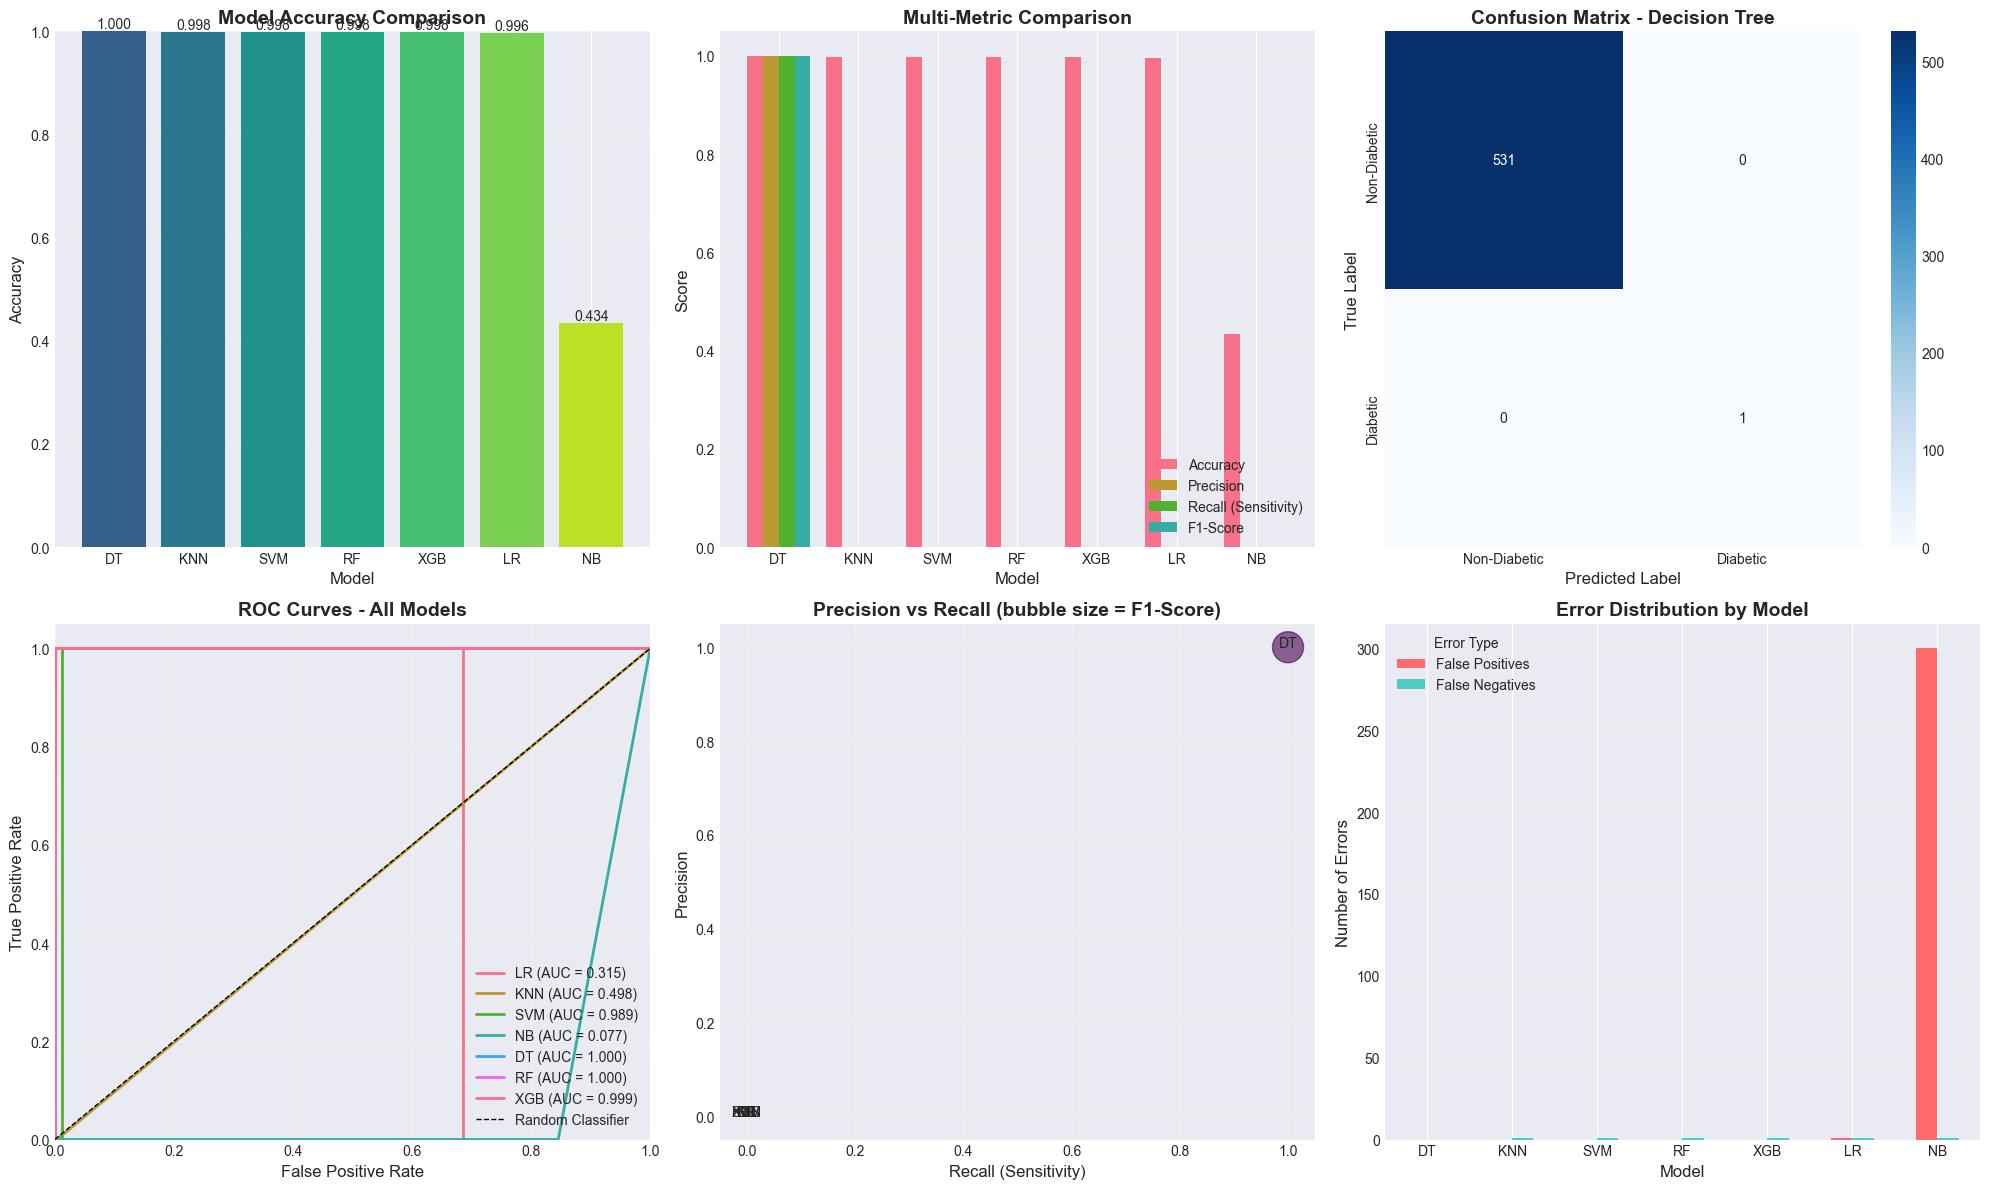

✓ Visualizations saved as 'model_comparison_complete.png'


In [39]:
# ============================================================================
# STEP 4: VISUALIZATIONS
# ============================================================================
print("\n📊 Generating visualizations...")

# Create a figure with subplots
fig = plt.figure(figsize=(20, 12))

# --- 1. Bar Chart: Accuracy Comparison ---
ax1 = plt.subplot(2, 3, 1)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(results_df)))
bars = ax1.bar(results_df['Abbreviation'], results_df['Accuracy'], color=colors)
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# --- 2. Multi-metric Comparison ---
ax2 = plt.subplot(2, 3, 2)
metrics_to_plot = ['Accuracy', 'Precision', 'Recall (Sensitivity)', 'F1-Score']
x = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    offset = (i - len(metrics_to_plot)/2) * width + width/2
    ax2.bar(x + offset, results_df[metric], width, label=metric)

ax2.set_xlabel('Model', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Multi-Metric Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(results_df['Abbreviation'])
ax2.legend(loc='lower right')
ax2.grid(axis='y', alpha=0.3)

# --- 3. Confusion Matrix Heatmap (Best Model) ---
ax3 = plt.subplot(2, 3, 3)
best_model_name = best_model['Model']
best_pred = models[best_model_name]['predictions']
cm_best = confusion_matrix(y_test, best_pred)

sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Diabetic', 'Diabetic'],
            yticklabels=['Non-Diabetic', 'Diabetic'], ax=ax3)
ax3.set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
ax3.set_ylabel('True Label', fontsize=12)
ax3.set_xlabel('Predicted Label', fontsize=12)

# --- 4. ROC Curves ---
ax4 = plt.subplot(2, 3, 4)
roc_data = []

for name, model_info in models.items():
    model = model_info['model']
    
    # Get probability predictions
    try:
        if name == 'SVM':
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if 'X_test_scaled' in globals() else model.predict_proba(X_test)[:, 1]
        else:
            y_pred_proba = model.predict_proba(X_test)[:, 1]
    except:
        # If predict_proba not available, use decision_function
        try:
            if name == 'SVM':
                y_pred_proba = model.decision_function(X_test_scaled) if 'X_test_scaled' in globals() else model.decision_function(X_test)
            else:
                y_pred_proba = model.decision_function(X_test)
        except:
            continue
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    roc_data.append({'Model': name, 'AUC': roc_auc})
    
    ax4.plot(fpr, tpr, label=f'{model_info["abbrev"]} (AUC = {roc_auc:.3f})', linewidth=2)

ax4.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
ax4.set_xlim([0.0, 1.0])
ax4.set_ylim([0.0, 1.05])
ax4.set_xlabel('False Positive Rate', fontsize=12)
ax4.set_ylabel('True Positive Rate', fontsize=12)
ax4.set_title('ROC Curves - All Models', fontsize=14, fontweight='bold')
ax4.legend(loc="lower right", fontsize=10)
ax4.grid(alpha=0.3)

# --- 5. Precision-Recall Comparison ---
ax5 = plt.subplot(2, 3, 5)
ax5.scatter(results_df['Recall (Sensitivity)'], results_df['Precision'], 
           s=results_df['F1-Score']*500, alpha=0.6, c=range(len(results_df)), cmap='viridis')

for idx, row in results_df.iterrows():
    ax5.annotate(row['Abbreviation'], 
                (row['Recall (Sensitivity)'], row['Precision']),
                fontsize=10, ha='center')

ax5.set_xlabel('Recall (Sensitivity)', fontsize=12)
ax5.set_ylabel('Precision', fontsize=12)
ax5.set_title('Precision vs Recall (bubble size = F1-Score)', fontsize=14, fontweight='bold')
ax5.grid(alpha=0.3)
ax5.set_xlim([-0.05, 1.05])
ax5.set_ylim([-0.05, 1.05])

# --- 6. Error Analysis ---
ax6 = plt.subplot(2, 3, 6)
error_data = pd.DataFrame({
    'False Positives': results_df['FP'].values,
    'False Negatives': results_df['FN'].values
}, index=results_df['Abbreviation'].values)

error_data.plot(kind='bar', ax=ax6, color=['#ff6b6b', '#4ecdc4'])
ax6.set_xlabel('Model', fontsize=12)
ax6.set_ylabel('Number of Errors', fontsize=12)
ax6.set_title('Error Distribution by Model', fontsize=14, fontweight='bold')
ax6.legend(title='Error Type')
ax6.grid(axis='y', alpha=0.3)
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('model_comparison_complete.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved as 'model_comparison_complete.png'")


In [40]:
# ============================================================================
# STEP 5: STATISTICAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)

# AUC Ranking
if roc_data:
    auc_df = pd.DataFrame(roc_data).sort_values('AUC', ascending=False)
    print("\n📊 AUC Ranking:")
    print("-" * 40)
    for idx, row in auc_df.iterrows():
        print(f"{row['Model']}: {row['AUC']:.4f}")

# Model consensus
print("\n🤝 Model Consensus Analysis:")
print("-" * 40)
agreement_matrix = np.zeros((len(y_test), len(models)))
for i, (name, model_info) in enumerate(models.items()):
    agreement_matrix[:, i] = model_info['predictions']

consensus = np.mean(agreement_matrix, axis=1)
print(f"Average agreement rate: {np.mean(consensus == consensus.round()):.2%}")



STATISTICAL SUMMARY

📊 AUC Ranking:
----------------------------------------
Decision Tree: 1.0000
Random Forest: 1.0000
XGBoost: 0.9991
SVM: 0.9887
KNN: 0.4981
Logistic Regression: 0.3145
Naive Bayes: 0.0772

🤝 Model Consensus Analysis:
----------------------------------------
Average agreement rate: 43.42%


In [41]:
# ============================================================================
# STEP 6: SAVE RESULTS
# ============================================================================
print("\n💾 Saving results...")

# Save detailed results
results_df.to_csv('model_comparison_detailed.csv', index=False)
print("✓ Detailed results saved to 'model_comparison_detailed.csv'")

# Save summary
summary = pd.DataFrame({
    'Metric': ['Best Model', 'Best Accuracy', 'Best F1-Score', 'Best AUC'],
    'Value': [
        best_model['Model'],
        f"{best_model['Accuracy']:.4f}",
        f"{best_model['F1-Score']:.4f}",
        f"{auc_df.iloc[0]['AUC']:.4f}" if roc_data else 'N/A'
    ]
})
summary.to_csv('model_comparison_summary.csv', index=False)
print("✓ Summary saved to 'model_comparison_summary.csv'")

print("\n" + "="*80)
print("✅ MODEL COMPARISON COMPLETE!")
print("="*80)
print("\nKey findings:")
print(f"• Best overall model: {best_model['Model']}")
print(f"• Highest accuracy: {best_model['Accuracy']:.4f}")
print(f"• Most consistent: {results_df.loc[results_df['MCC'].idxmax(), 'Model']} (highest MCC)")
print(f"• Best for avoiding false positives: {results_df.loc[results_df['Precision'].idxmax(), 'Model']}")
print(f"• Best for catching all diabetics: {results_df.loc[results_df['Recall (Sensitivity)'].idxmax(), 'Model']}")
print("="*80)


💾 Saving results...
✓ Detailed results saved to 'model_comparison_detailed.csv'
✓ Summary saved to 'model_comparison_summary.csv'

✅ MODEL COMPARISON COMPLETE!

Key findings:
• Best overall model: Decision Tree
• Highest accuracy: 1.0000
• Most consistent: Decision Tree (highest MCC)
• Best for avoiding false positives: Decision Tree
• Best for catching all diabetics: Decision Tree


In [ ]:
# ============================================================================
# KERAS DEEP NEURAL NETWORK (DNN) FOR T2DM PREDICTION
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import Keras/TensorFlow
try:
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from tensorflow.keras.regularizers import l2
    print("✓ TensorFlow/Keras imported successfully")
except ImportError:
    print("⚠️ TensorFlow not installed. Installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow"])
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from tensorflow.keras.regularizers import l2

print("\n" + "="*80)
print("3.8 KERAS DEEP NEURAL NETWORK (DNN)")
print("="*80)

# ============================================================================
# STEP 1: DATA PREPARATION
# ============================================================================
print("\n📊 Preparing data for DNN...")

# Check if scaled data exists (recommended for neural networks)
try:
    X_train_dnn = X_train_scaled.values if hasattr(X_train_scaled, 'values') else X_train_scaled
    X_test_dnn = X_test_scaled.values if hasattr(X_test_scaled, 'values') else X_test_scaled
    print("✓ Using scaled data (recommended for DNN)")
except:
    # If scaled data doesn't exist, scale it now
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train_dnn = scaler.fit_transform(X_train)
    X_test_dnn = scaler.transform(X_test)
    print("✓ Data scaled for DNN")

# Ensure y is numpy array and correct shape
y_train_dnn = np.array(y_train).astype(int)
y_test_dnn = np.array(y_test).astype(int)

# Get input dimension
input_dim = X_train_dnn.shape[1]
print(f"Input dimension: {input_dim}")
print(f"Training samples: {X_train_dnn.shape[0]}")
print(f"Test samples: {X_test_dnn.shape[0]}")

# ============================================================================
# STEP 2: BUILD DNN MODEL
# ============================================================================
print("\n🏗️ Building DNN architecture...")

def create_dnn_model(input_dim, learning_rate=0.001):
    """
    Create a Deep Neural Network for binary classification
    
    Architecture:
    - Input layer
    - Hidden layer 1: 128 neurons with ReLU
    - Dropout layer: 0.3
    - Hidden layer 2: 64 neurons with ReLU
    - Batch Normalization
    - Dropout layer: 0.2
    - Hidden layer 3: 32 neurons with ReLU
    - Output layer: 1 neuron with sigmoid (binary classification)
    """
    
    model = Sequential([
        # First hidden layer
        Dense(128, activation='relu', input_dim=input_dim, 
              kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        
        # Second hidden layer
        Dense(64, activation='relu', 
              kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        
        # Third hidden layer
        Dense(32, activation='relu'),
        Dropout(0.1),
        
        # Output layer
        Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create the model
DNN = create_dnn_model(input_dim)

# Display model architecture
print("\nModel Architecture:")
print("-" * 50)
DNN.summary()

# ============================================================================
# STEP 3: TRAIN MODEL WITH CALLBACKS
# ============================================================================
print("\n🎯 Training DNN model...")

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=0.00001,
    verbose=1
)

# Train the model
history = DNN.fit(
    X_train_dnn, y_train_dnn,
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=0  # Set to 1 to see training progress
)

print(f"✓ Training completed in {len(history.history['loss'])} epochs")

# ============================================================================
# STEP 4: EVALUATE MODEL
# ============================================================================
print("\n📈 Evaluating DNN performance...")

# Make predictions
y_pred_dnn_prob = DNN.predict(X_test_dnn).flatten()
y_pred_dnn = (y_pred_dnn_prob > 0.5).astype(int)

# Calculate metrics
accuracy_dnn = accuracy_score(y_test_dnn, y_pred_dnn)
precision_dnn = precision_score(y_test_dnn, y_pred_dnn, zero_division=0)
recall_dnn = recall_score(y_test_dnn, y_pred_dnn, zero_division=0)
f1_dnn = f1_score(y_test_dnn, y_pred_dnn, zero_division=0)

print(f'\nAccuracy for testing: {accuracy_dnn:.4f}')
print(f'Precision: {precision_dnn:.4f}')
print(f'Recall: {recall_dnn:.4f}')
print(f'F1-Score: {f1_dnn:.4f}')

print("\nConfusion Matrix:")
cm_dnn = confusion_matrix(y_test_dnn, y_pred_dnn)
print(cm_dnn)

print("\nClassification Report:")
print(classification_report(y_test_dnn, y_pred_dnn, digits=4))

# Store confusion matrix
cf_matrix_DNN = cm_dnn

# ============================================================================
# STEP 5: CROSS-VALIDATION (Optional - takes longer)
# ============================================================================
print("\n🔄 Performing cross-validation (this may take a minute)...")

# Simplified cross-validation
cv_scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=2)

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_dnn), 1):
    # Create a new model for each fold
    model_cv = create_dnn_model(input_dim)
    
    # Get fold data
    X_fold_train, X_fold_val = X_train_dnn[train_idx], X_train_dnn[val_idx]
    y_fold_train, y_fold_val = y_train_dnn[train_idx], y_train_dnn[val_idx]
    
    # Train model
    model_cv.fit(
        X_fold_train, y_fold_train,
        epochs=50,  # Fewer epochs for CV
        batch_size=32,
        verbose=0
    )
    
    # Evaluate
    y_pred_fold = (model_cv.predict(X_fold_val).flatten() > 0.5).astype(int)
    fold_accuracy = accuracy_score(y_fold_val, y_pred_fold)
    cv_scores.append(fold_accuracy)
    print(f"Fold {fold}: {fold_accuracy:.4f}")

print(f"\nCross-validation accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

# ============================================================================
# STEP 6: VISUALIZE TRAINING HISTORY
# ============================================================================
print("\n📊 Generating training visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy Over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot training & validation loss
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss Over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('dnn_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training history saved as 'dnn_training_history.png'")

# ============================================================================
# STEP 7: ROC CURVE
# ============================================================================
print("\n📈 Generating ROC curve...")

fpr_dnn, tpr_dnn, _ = roc_curve(y_test_dnn, y_pred_dnn_prob)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dnn, tpr_dnn, color='darkorange', lw=2, 
         label=f'DNN ROC curve (AUC = {roc_auc_dnn:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Deep Neural Network')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig('dnn_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ ROC curve saved. AUC: {roc_auc_dnn:.4f}")

# ============================================================================
# STEP 8: ADD TO MODEL COMPARISON
# ============================================================================
print("\n🔄 Adding DNN to model comparison...")

# Make sure the model and predictions are available globally
globals()['DNN'] = DNN
globals()['y_pred_dnn'] = y_pred_dnn

print("✓ DNN model saved as 'DNN'")
print("✓ Predictions saved as 'y_pred_dnn'")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("DEEP NEURAL NETWORK TRAINING COMPLETE!")
print("="*80)
print(f"Final Test Accuracy: {accuracy_dnn:.4f}")
print(f"Final Test F1-Score: {f1_dnn:.4f}")
print(f"ROC AUC Score: {roc_auc_dnn:.4f}")
print("\nModel is ready for comparison with other algorithms.")
print("You can now include DNN in your model comparison by running the comparison code again.")
print("="*80)